In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
import emoji
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from collections import Counter

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

# NLTK imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer

# Additional imports for embeddings
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import os

# Filter warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK packages
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def extract_rich_text_features(text):
    """
    Extract rich text features including punctuation, capitalization, and emojis
    """
    if pd.isna(text):
        return {
            'exclamation_count': 0,
            'question_count': 0,
            'uppercase_ratio': 0,
            'uppercase_word_count': 0,
            'emoji_count': 0,
            'has_disaster_emoji': 0,
            'punctuation_ratio': 0,
            'emphasis_punctuation': 0,
            'avg_word_length': 0,
            'hashtag_count': 0,
            'mention_count': 0,
            'disaster_emoji_list': '',
            'multiple_punctuation': 0,
            'all_caps_words': 0
        }
    
    text = str(text)
    original_length = len(text)
    
    features = {}
    
    # Punctuation features
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    
    # Total punctuation count
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    features['punctuation_ratio'] = punctuation_count / original_length if original_length > 0 else 0
    
    # Emphasis patterns (!!!, ???, etc.)
    emphasis_pattern = re.compile(r'(!{2,}|\?{2,}|\.{3,})')
    emphasis_matches = emphasis_pattern.findall(text)
    features['emphasis_punctuation'] = len(emphasis_matches)
    
    # Multiple punctuation (e.g., '?!', '!!?')
    multiple_punct_pattern = re.compile(r'[!?.]{2,}')
    features['multiple_punctuation'] = len(multiple_punct_pattern.findall(text))
    
    # Tokenize with TweetTokenizer to better handle social media text
    tokenizer = TweetTokenizer(preserve_case=True)
    words = tokenizer.tokenize(text)
    
    # Capitalization features
    uppercase_words = [w for w in words if w.isupper() and len(w) > 1]
    features['uppercase_word_count'] = len(uppercase_words)
    
    word_count = len([w for w in words if w.isalpha()])
    features['uppercase_ratio'] = len(uppercase_words) / word_count if word_count > 0 else 0
    
    # All caps words feature
    features['all_caps_words'] = len([w for w in words if w.isupper() and len(w) >= 3])
    
    # Word features
    if word_count > 0:
        features['avg_word_length'] = sum(len(w) for w in words if w.isalpha()) / word_count
    else:
        features['avg_word_length'] = 0
    
    # Twitter-specific features
    features['hashtag_count'] = len(re.findall(r'#\w+', text))
    features['mention_count'] = len(re.findall(r'@\w+', text))
    
    # Emoji features
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    features['emoji_count'] = len(emoji_list)
    
    # Disaster-related emojis (expanded list)
    disaster_emojis = {
        '🔥': 'fire', '💧': 'water', '🌊': 'wave', '💥': 'explosion',
        '🌪️': 'tornado', '🌫️': 'fog', '⚡': 'lightning', '🌩️': 'thunderstorm',
        '🌧️': 'rain', '🌨️': 'snow', '🏚️': 'damaged_house', '🚨': 'alarm',
        '🚑': 'ambulance', '🚒': 'fire_truck', '⚠️': 'warning', '☣️': 'biohazard',
        '☢️': 'radioactive', '🆘': 'sos', '📢': 'loudspeaker', '🚁': 'helicopter',
        '🚓': 'police_car', '🌋': 'volcano', '💨': 'wind', '🌀': 'cyclone'
    }
    
    disaster_emojis_found = [emoji for emoji in emoji_list if emoji in disaster_emojis]
    features['has_disaster_emoji'] = 1 if disaster_emojis_found else 0
    features['disaster_emoji_list'] = ','.join([disaster_emojis.get(e, '') for e in disaster_emojis_found])
    
    return features

def enrich_dataframe_with_text_features(df, text_column='text'):
    """Extract rich text features and add them to the DataFrame"""
    print("Extracting rich text features...")
    
    # Apply the feature extraction function to each tweet
    rich_features = df[text_column].apply(extract_rich_text_features)
    
    # Convert list of dictionaries to DataFrame
    rich_features_df = pd.DataFrame(rich_features.tolist())
    
    # Combine with original DataFrame
    enriched_df = pd.concat([df.reset_index(drop=True), rich_features_df.reset_index(drop=True)], axis=1)
    
    return enriched_df

print("Rich text feature extraction functions defined!")

Rich text feature extraction functions defined!


In [3]:
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin into a single string
    clean_text = ' '.join(tokens)
    
    return clean_text

def preprocess_disaster_data(disaster_df, require_predicted_label=False, use_rich_features=True):
    """Preprocess disaster dataset with option for rich text features"""
    df = disaster_df.copy()
    
    # Fill missing values
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)
    
    # Clean text
    print("Cleaning text...")
    df['clean_text'] = df['text'].apply(clean_text)
    
    # Add rich text features if requested
    if use_rich_features:
        df = enrich_dataframe_with_text_features(df)
    
    # Check if predicted_label is present
    if 'predicted_label' in df.columns:
        valid_labels = set([0, 1, 2])
        actual_labels = set(df['predicted_label'].unique())
        
        if not actual_labels.issubset(valid_labels):
            raise ValueError(f"predicted_label should only contain values 0, 1, 2. Found: {actual_labels}")
    elif require_predicted_label:
        raise ValueError("Dataset must contain a 'predicted_label' column")
    
    return df

print("Text preprocessing functions defined!")

Text preprocessing functions defined!


In [4]:
def load_data(train_path, test_path, sentiment_path):
    """Load disaster and sentiment datasets"""
    print(f"Loading training data from {train_path}...")
    disaster_train = pd.read_csv(train_path)
    
    print(f"Loading test data from {test_path}...")
    disaster_test = pd.read_csv(test_path)
    
    print(f"Loading sentiment data from {sentiment_path}...")
    sentiment_data = pd.read_csv(sentiment_path)
    
    # Print dataset info
    print(f"Disaster train shape: {disaster_train.shape}")
    print(f"Disaster test shape: {disaster_test.shape}")
    print(f"Sentiment data shape: {sentiment_data.shape}")
    
    # Check predicted_label distribution in training data
    if 'predicted_label' in disaster_train.columns:
        print("\nPredicted label distribution in train:")
        class_counts = disaster_train['predicted_label'].value_counts().sort_index()
        for class_id, count in class_counts.items():
            percentage = (count / len(disaster_train)) * 100
            print(f"Class {class_id}: {count} ({percentage:.2f}%)")
    else:
        raise ValueError("Training dataset must contain a 'predicted_label' column")
    
    # Check if test data has target column
    if 'target' in disaster_test.columns:
        print("\nBinary target distribution in test:")
        print(disaster_test['target'].value_counts())
    
    return disaster_train, disaster_test, sentiment_data

print("Data loading functions defined!")

Data loading functions defined!


In [5]:
def load_word_embeddings(glove_path=None, word2vec_path=None):
    """
    Load GloVe and/or Word2Vec models for embeddings
    
    Parameters:
    glove_path : str, path to GloVe embeddings file (e.g., 'glove.6B.100d.txt')
    word2vec_path : str, path to Word2Vec embeddings file in word2vec format
    
    Returns:
    Dict containing the loaded models
    """
    embeddings = {}
    
    if glove_path and os.path.exists(glove_path):
        print(f"Loading GloVe embeddings from {glove_path}...")
        # Convert GloVe format to Word2Vec format if not already converted
        temp_file = f"{glove_path}.word2vec"
        if not os.path.exists(temp_file):
            print("Converting GloVe to Word2Vec format...")
            glove2word2vec(glove_path, temp_file)
        
        # Load GloVe vectors in Word2Vec format
        embeddings['glove'] = KeyedVectors.load_word2vec_format(temp_file)
        print(f"Loaded GloVe embeddings with {len(embeddings['glove'].key_to_index)} words")
    
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Loading Word2Vec embeddings from {word2vec_path}...")
        embeddings['word2vec'] = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
        print(f"Loaded Word2Vec embeddings with {len(embeddings['word2vec'].key_to_index)} words")
    
    return embeddings

def get_text_embedding(text, embedding_model, embedding_size):
    """
    Get the embedding vector for a text by averaging word vectors
    
    Parameters:
    text : str, the text to embed
    embedding_model : KeyedVectors, the embedding model to use
    embedding_size : int, size of the embedding vectors
    
    Returns:
    numpy array of shape (embedding_size,) with the text embedding
    """
    if pd.isna(text) or text == "":
        return np.zeros(embedding_size)
    
    # Tokenize the text
    words = text.lower().split()
    
    # Get embeddings for words that exist in the model
    word_vectors = [embedding_model[word] for word in words if word in embedding_model]
    
    # Return average of word vectors or zeros if no words found
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_size)

print("Word embeddings functions defined!")

Word embeddings functions defined!


In [6]:
def build_improved_sentiment_model_with_embeddings(sentiment_data, embeddings, embedding_type='glove'):
    """
    Build and train an improved sentiment analysis model using word embeddings
    
    Parameters:
    sentiment_data : DataFrame, the sentiment dataset
    embeddings : dict, contains the loaded embedding models
    embedding_type : str, 'glove' or 'word2vec' to specify which embeddings to use
    
    Returns:
    tuple containing the model, embedding info, and other metadata
    """
    print(f"Building improved sentiment analysis model with {embedding_type} embeddings...")
    
    # Clean text
    sentiment_data['clean_content'] = sentiment_data['content'].apply(clean_text)
    
    # Convert sentiment to numeric categories
    sentiment_mapping = {
        'empty': 0, 'sadness': 1, 'enthusiasm': 2, 'neutral': 3,
        'worry': 4, 'surprise': 5, 'love': 6, 'fun': 7,
        'hate': 8, 'happiness': 9, 'relief': 10, 'anger': 11,
        'boredom': 12
    }
    
    sentiment_data['sentiment_code'] = sentiment_data['sentiment'].map(sentiment_mapping)
    
    if embedding_type not in embeddings:
        raise ValueError(f"{embedding_type} embeddings not loaded. Please load them first.")
    
    embedding_model = embeddings[embedding_type]
    embedding_size = embedding_model.vector_size
    
    print(f"Embedding size: {embedding_size}")
    
    # Extract embeddings
    print("Extracting embeddings for sentiment data...")
    X_embeddings = np.array([
        get_text_embedding(text, embedding_model, embedding_size) 
        for text in sentiment_data['clean_content']
    ])
    
    y_sentiment = sentiment_data['sentiment_code']
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_embeddings, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
    )
    
    # Create pipeline with scaling and SVM classifier
    sentiment_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(C=10.0, gamma='scale', probability=True, random_state=42))
    ])
    
    # Train the model
    print("Training sentiment model...")
    sentiment_pipeline.fit(X_train, y_train)
    
    # Evaluate
    y_pred = sentiment_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Sentiment Model Accuracy: {accuracy:.4f}")
    
    # Show classification report
    print("\nSentiment Model Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Return the pipeline and embedding information
    return sentiment_pipeline, embedding_model, embedding_size, sentiment_mapping
    
def extract_sentiment_features_with_embeddings(df, sentiment_model, embedding_model, embedding_size, sentiment_mapping):
    """
    Extract sentiment features from tweets using the embedding-based model
    
    Parameters:
    df : DataFrame, the dataset to extract features from
    sentiment_model : Pipeline, the trained sentiment model
    embedding_model : KeyedVectors, the embedding model used
    embedding_size : int, size of the embeddings
    sentiment_mapping : dict, mapping from sentiment labels to numeric codes
    
    Returns:
    DataFrame with sentiment features added
    """
    print("Extracting sentiment features using embeddings...")
    
    if 'clean_text' not in df.columns:
        df['clean_text'] = df['text'].apply(clean_text)
    
    # Extract embeddings for each tweet
    print("Computing embeddings for tweets...")
    X_embeddings = np.array([
        get_text_embedding(text, embedding_model, embedding_size) 
        for text in df['clean_text']
    ])
    
    # Predict sentiment
    print("Predicting sentiment...")
    sentiment_pred = sentiment_model.predict(X_embeddings)
    
    # Get sentiment probabilities
    sentiment_proba = sentiment_model.predict_proba(X_embeddings)
    
    # Create a DataFrame with sentiment probabilities
    sentiment_columns = [f'sentiment_{key}' for key in sentiment_mapping.keys()]
    sentiment_df = pd.DataFrame(sentiment_proba, columns=sentiment_columns)
    
    # Add predicted sentiment class
    df['predicted_sentiment'] = sentiment_pred
    
    # Add embedding features (reduce dimension for efficiency)
    # Take the first 10 dimensions of each embedding as features
    embed_features = pd.DataFrame(
        X_embeddings[:, :10], 
        columns=[f'embed_dim_{i}' for i in range(10)]
    )
    
    # Combine with sentiment probabilities
    result_df = pd.concat([df.reset_index(drop=True), 
                          sentiment_df.reset_index(drop=True), 
                          embed_features.reset_index(drop=True)], 
                         axis=1)
    
    return result_df

print("Sentiment model with embeddings functions defined!")

Sentiment model with embeddings functions defined!


In [7]:
def extract_features(df_train, df_test=None, tfidf_max_features=5000, use_rich_features=True):
    """Extract features from preprocessed data including rich text features if available"""
    print("Extracting TF-IDF and categorical features...")
    
    # TF-IDF for text with improved parameters
    tfidf = TfidfVectorizer(max_features=tfidf_max_features, ngram_range=(1, 2), min_df=2)
    
    # Fit on training data
    X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
    
    # Transform test data if provided
    X_test_tfidf = None
    if df_test is not None:
        X_test_tfidf = tfidf.transform(df_test['clean_text'])
    
    # Get clean feature names
    feature_names = []
    for name in tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        feature_names.append(f'tfidf_{clean_name}')
    
    # Convert to DataFrame
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
    
    test_tfidf_df = None
    if X_test_tfidf is not None:
        test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)
    
    # Categorical features
    categorical_features = ['keyword', 'location']
    
    # Initialize the encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit on training data
    encoder.fit(df_train[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    # Transform training data
    train_cat_encoded = encoder.transform(df_train[categorical_features])
    train_cat_df = pd.DataFrame(train_cat_encoded, columns=cat_feature_names)
    
    # Transform test data if provided
    test_cat_df = None
    if df_test is not None:
        test_cat_encoded = encoder.transform(df_test[categorical_features])
        test_cat_df = pd.DataFrame(test_cat_encoded, columns=cat_feature_names)
    
    # Combine text and categorical features
    X_train_features = pd.concat([train_tfidf_df, train_cat_df], axis=1)
    X_test_features = None
    
    if test_tfidf_df is not None and test_cat_df is not None:
        X_test_features = pd.concat([test_tfidf_df, test_cat_df], axis=1)
    
    # Add rich text features if available and requested
    if use_rich_features:
        rich_feature_cols = [
            'exclamation_count', 'question_count', 'uppercase_ratio', 
            'uppercase_word_count', 'emoji_count', 'has_disaster_emoji',
            'punctuation_ratio', 'emphasis_punctuation', 'avg_word_length',
            'hashtag_count', 'mention_count', 'multiple_punctuation', 'all_caps_words'
        ]
        
        # Check if rich features are available
        if all(col in df_train.columns for col in rich_feature_cols):
            print("Adding rich text features...")
            rich_train_df = df_train[rich_feature_cols]
            X_train_features = pd.concat([X_train_features, rich_train_df], axis=1)
            
            if df_test is not None and X_test_features is not None:
                if all(col in df_test.columns for col in rich_feature_cols):
                    rich_test_df = df_test[rich_feature_cols]
                    X_test_features = pd.concat([X_test_features, rich_test_df], axis=1)
        else:
            print("Rich text features not found in the data.")
    
    return X_train_features, X_test_features, tfidf, encoder, feature_names, cat_feature_names

print("Feature extraction functions defined!")

Feature extraction functions defined!


In [8]:
def build_and_evaluate_models(X_train, y_train, X_val=None, y_val=None, models=None):
    """Build and evaluate multiple models, with option for validation set or cross-validation"""
    if models is None:
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=300, 
                max_depth=25, 
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=300, 
                max_depth=7, 
                learning_rate=0.1,
                random_state=42
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=300, 
                max_depth=7, 
                learning_rate=0.1, 
                random_state=42,
                enable_categorical=False,
                use_label_encoder=False,
                tree_method='hist',
                objective='multi:softprob',
                num_class=3,
                eval_metric='mlogloss'
            )
        }
    
    results = {}
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    # If validation set is provided
    if X_val is not None and y_val is not None:
        print("\nEvaluating models using train-validation split...")
        
        for model_name, model in models.items():
            print(f"\n===== Training {model_name} =====")
            start_time = time.time()
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average='weighted')
            recall = recall_score(y_val, y_pred, average='weighted')
            macro_f1 = f1_score(y_val, y_pred, average='macro')
            weighted_f1 = f1_score(y_val, y_pred, average='weighted')
            
            training_time = time.time() - start_time
            
            # Print metrics
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"Macro F1: {macro_f1:.4f}")
            print(f"Weighted F1: {weighted_f1:.4f}")
            print(f"Training time: {training_time:.2f} seconds")
            
            # Classification report
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred, target_names=list(class_labels.values())))
            
            # Store results
            results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'macro_f1': macro_f1,
                'weighted_f1': weighted_f1,
                'training_time': training_time
            }
    
    # Use cross-validation
    else:
        print("\nEvaluating models using 5-fold cross-validation...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for model_name, model in models.items():
            print(f"\n===== Cross-validating {model_name} =====")
            start_time = time.time()
            
            # Cross-validation scores
            cv_scores = {
                'accuracy': cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy'),
                'precision': cross_val_score(model, X_train, y_train, cv=cv, scoring='precision_weighted'),
                'recall': cross_val_score(model, X_train, y_train, cv=cv, scoring='recall_weighted'),
                'f1_macro': cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro'),
                'f1_weighted': cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
            }
            
            cv_time = time.time() - start_time
            
            # Print results
            for metric, scores in cv_scores.items():
                print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")
            print(f"Cross-validation time: {cv_time:.2f} seconds")
            
            # Store results
            results[model_name] = {
                'model': None,
                **{f"{metric}_mean": scores.mean() for metric, scores in cv_scores.items()},
                **{f"{metric}_std": scores.std() for metric, scores in cv_scores.items()},
                'cv_time': cv_time
            }
        
        # Train the best model on the full dataset
        best_model_name = max(results, key=lambda m: results[m]['f1_weighted_mean'])
        print(f"\nTraining {best_model_name} on the full dataset...")
        
        best_model = models[best_model_name]
        best_model.fit(X_train, y_train)
        results[best_model_name]['model'] = best_model
    
    # Print comparison table
    print("\n===== MODEL COMPARISON =====")
    comparison_df = pd.DataFrame(results).T
    print(comparison_df)
    
    # Find best model based on weighted F1 score
    best_model_name = max(results, key=lambda m: results[m].get('weighted_f1', results[m].get('f1_weighted_mean', 0)))
    print(f"\nBest model: {best_model_name}")
    
    return results, best_model_name

print("Model building and evaluation functions defined!")

Model building and evaluation functions defined!


In [9]:
def evaluate_on_test_data(best_model, X_test, test_df):
    """Evaluate the best model on test data and map to original binary classes"""
    print("\n===== EVALUATING ON TEST DATA =====")
    
    # Make predictions on test data
    y_pred = best_model.predict(X_test)
    probabilities = best_model.predict_proba(X_test)
    
    # Get class distribution
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    # Print prediction distribution
    print("\nPrediction distribution on test data:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for class_id, count in pred_counts.items():
        percentage = (count / len(y_pred)) * 100
        print(f"Class {class_id} ({class_labels[class_id]}): {count} tweets ({percentage:.2f}%)")
    
    # Add predictions to the test dataframe
    test_df['predicted_multiclass'] = y_pred
    test_df['predicted_label'] = test_df['predicted_multiclass'].map(class_labels)
    
    # Add probabilities
    for i, class_id in enumerate(range(3)):
        test_df[f'class_{class_id}_prob'] = probabilities[:, i]
    
    # If original binary target is available, evaluate compatibility
    if 'target' in test_df.columns:
        print("\nEvaluating compatibility with original binary labels:")
        
        # Map our 3-class predictions to binary (classes 0 and 1 → 1, class 2 → 0)
        binary_pred = np.where(y_pred == 2, 0, 1)
        
        # Calculate binary metrics
        binary_accuracy = accuracy_score(test_df['target'], binary_pred)
        binary_precision = precision_score(test_df['target'], binary_pred)
        binary_recall = recall_score(test_df['target'], binary_pred)
        binary_f1 = f1_score(test_df['target'], binary_pred)
        
        print(f"Binary Accuracy: {binary_accuracy:.4f} ({binary_accuracy*100:.2f}%)")
        print(f"Binary Precision: {binary_precision:.4f}")
        print(f"Binary Recall: {binary_recall:.4f}")
        print(f"Binary F1-score: {binary_f1:.4f}")
        
        # Create binary confusion matrix
        binary_cm = confusion_matrix(test_df['target'], binary_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Disaster", "Disaster"], 
                    yticklabels=["Not Disaster", "Disaster"])
        plt.xlabel("Predicted (Binary)")
        plt.ylabel("Actual (Binary)")
        plt.title("Binary Compatibility Confusion Matrix")
        plt.tight_layout()
        plt.show()
        
        # Add binary predictions to the dataframe
        test_df['predicted_binary'] = binary_pred
    
    return test_df

print("Test data evaluation functions defined!")

Test data evaluation functions defined!


In [10]:
def main_pipeline_with_embeddings(train_path, test_path, sentiment_path, 
                                 glove_path=None, word2vec_path=None,
                                 embedding_type='glove',
                                 output_model_path=None, 
                                 output_test_path=None, 
                                 eval_method='cv', 
                                 use_rich_features=True):
    """
    Main pipeline that ties everything together with embedding-based sentiment model
    """
    # 1. Load Data
    print("="*50)
    print("STEP 1: LOADING DATA")
    print("="*50)
    disaster_train, disaster_test, sentiment_data = load_data(train_path, test_path, sentiment_path)
    
    # 2. Preprocess Data
    print("\n" + "="*50)
    print("STEP 2: PREPROCESSING DATA")
    print("="*50)
    disaster_train_processed = preprocess_disaster_data(disaster_train, require_predicted_label=True, use_rich_features=use_rich_features)
    disaster_test_processed = preprocess_disaster_data(disaster_test, require_predicted_label=False, use_rich_features=use_rich_features)
    
    # 3. Load Word Embeddings
    print("\n" + "="*50)
    print(f"STEP 3: LOADING {embedding_type.upper()} EMBEDDINGS")
    print("="*50)
    embeddings = load_word_embeddings(glove_path, word2vec_path)
    
    if embedding_type not in embeddings:
        raise ValueError(f"{embedding_type} embeddings not loaded. Check the path and try again.")
    
    # 4. Build Sentiment Model with Embeddings
    print("\n" + "="*50)
    print(f"STEP 4: BUILDING SENTIMENT MODEL WITH {embedding_type.upper()} EMBEDDINGS")
    print("="*50)
    sentiment_model, embedding_model, embedding_size, sentiment_mapping = build_improved_sentiment_model_with_embeddings(
        sentiment_data, embeddings, embedding_type
    )
    
    # 5. Extract Sentiment Features with Embeddings
    print("\n" + "="*50)
    print("STEP 5: EXTRACTING SENTIMENT FEATURES WITH EMBEDDINGS")
    print("="*50)
    disaster_train_with_sentiment = extract_sentiment_features_with_embeddings(
        disaster_train_processed, sentiment_model, embedding_model, 
        embedding_size, sentiment_mapping
    )
    
    disaster_test_with_sentiment = extract_sentiment_features_with_embeddings(
        disaster_test_processed, sentiment_model, embedding_model, 
        embedding_size, sentiment_mapping
    )
    
    # 6. Extract All Features
    print("\n" + "="*50)
    print("STEP 6: EXTRACTING ALL FEATURES")
    print("="*50)
    X_train_features, X_test_features, tfidf, encoder, tfidf_features, cat_features = extract_features(
        disaster_train_with_sentiment, disaster_test_with_sentiment, use_rich_features=use_rich_features
    )
    
    # 7. Get target variable for training
    y_train = disaster_train_with_sentiment['predicted_label']
    
    # 8. Model Comparison and Training
    print("\n" + "="*50)
    print("STEP 7: MODEL COMPARISON AND TRAINING")
    print("="*50)
    
    if eval_method == 'split':
        # Use train-validation split
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        results, best_model_name = build_and_evaluate_models(
            X_train_split, y_train_split, X_val_split, y_val_split
        )
    else:
        # Use cross-validation
        results, best_model_name = build_and_evaluate_models(X_train_features, y_train)
    
    # Get the best model
    best_model = results[best_model_name]['model']
    
    # 9. Evaluate on Test Data
    print("\n" + "="*50)
    print("STEP 8: EVALUATING ON TEST DATA")
    print("="*50)
    test_with_predictions = evaluate_on_test_data(best_model, X_test_features, disaster_test_with_sentiment.copy())
    
    # 10. Save the model and preprocessing objects
    if output_model_path is None:
        output_model_path = f"best_{best_model_name}_multiclass_model_with_{embedding_type}.pkl"
    
    print(f"\nSaving best model ({best_model_name}) to {output_model_path}")
    with open(output_model_path, 'wb') as f:
        pickle.dump({
            'model': best_model,
            'model_type': best_model_name,
            'tfidf': tfidf,
            'encoder': encoder,
            'sentiment_model': sentiment_model,
            'embedding_model': embedding_model,
            'embedding_size': embedding_size,
            'embedding_type': embedding_type,
            'sentiment_mapping': sentiment_mapping,
            'feature_names': X_train_features.columns.tolist(),
            'tfidf_features': tfidf_features,
            'cat_features': cat_features,
            'use_rich_features': use_rich_features
        }, f)
    
    # 11. Save the test predictions
    if output_test_path is None:
        output_test_path = f"test_with_predictions_{embedding_type}.csv"
    
    print(f"Saving test predictions to {output_test_path}")
    test_with_predictions.to_csv(output_test_path, index=False)
    
    return best_model, test_with_predictions, results

print("Main pipeline with embeddings function defined!")

Main pipeline with embeddings function defined!


In [11]:
def predict_single_tweet_with_embeddings(tweet_text, model_path, 
                                        keyword="", location=""):
    """Predict class for a single tweet with embedding-based sentiment model"""
    
    # Load model and preprocessing objects
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model = model_data['model']
    tfidf = model_data['tfidf']
    encoder = model_data['encoder']
    sentiment_model = model_data['sentiment_model']
    embedding_model = model_data['embedding_model']
    embedding_size = model_data['embedding_size']
    sentiment_mapping = model_data['sentiment_mapping']
    feature_names = model_data['feature_names']
    use_rich_features = model_data.get('use_rich_features', True)
    
    # Create a DataFrame with the tweet
    tweet_df = pd.DataFrame({
        'text': [tweet_text],
        'keyword': [keyword],
        'location': [location]
    })
    
    # Preprocess the tweet
    tweet_df['clean_text'] = tweet_df['text'].apply(clean_text)
    
    # Extract rich text features if enabled
    if use_rich_features:
        tweet_df = enrich_dataframe_with_text_features(tweet_df)
    
    # Extract sentiment features with embeddings
    tweet_df = extract_sentiment_features_with_embeddings(
        tweet_df, sentiment_model, embedding_model,
        embedding_size, sentiment_mapping
    )
    
    # Extract TF-IDF features
    tweet_tfidf = tfidf.transform(tweet_df['clean_text'])
    tfidf_feature_names = []
    for name in tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        tfidf_feature_names.append(f'tfidf_{clean_name}')
    
    tweet_tfidf_df = pd.DataFrame(tweet_tfidf.toarray(), columns=tfidf_feature_names)
    
    # Extract categorical features
    categorical_features = ['keyword', 'location']
    tweet_cat = encoder.transform(tweet_df[categorical_features])
    
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    tweet_cat_df = pd.DataFrame(tweet_cat, columns=cat_feature_names)
    
    # Combine features
    tweet_features = pd.concat([tweet_tfidf_df, tweet_cat_df], axis=1)
    
    # Add rich text features if enabled
    if use_rich_features:
        rich_feature_cols = [
            'exclamation_count', 'question_count', 'uppercase_ratio', 
            'uppercase_word_count', 'emoji_count', 'has_disaster_emoji',
            'punctuation_ratio', 'emphasis_punctuation', 'avg_word_length',
            'hashtag_count', 'mention_count', 'multiple_punctuation', 'all_caps_words'
        ]
        if all(col in tweet_df.columns for col in rich_feature_cols):
            rich_features_df = tweet_df[rich_feature_cols]
            tweet_features = pd.concat([tweet_features, rich_features_df], axis=1)
    
    # Ensure all features are present
    for col in feature_names:
        if col not in tweet_features.columns:
            tweet_features[col] = 0
    
    # Reorder to match training features
    tweet_features = tweet_features[feature_names]
    
    # Make prediction
    prediction = model.predict(tweet_features)[0]
    prediction_proba = model.predict_proba(tweet_features)[0]
    
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    result = {
        'prediction_class': int(prediction),
        'prediction_label': class_labels[prediction],
        'probabilities': {
            'class_0': float(prediction_proba[0]),
            'class_1': float(prediction_proba[1]),
            'class_2': float(prediction_proba[2])
        },
        'sentiment': list(sentiment_mapping.keys())[list(sentiment_mapping.values()).index(tweet_df['predicted_sentiment'].iloc[0])]
    }
    
    return result

print("Prediction function with embeddings defined!")

Prediction function with embeddings defined!


In [12]:
def visualize_model_comparison(results):
    """Visualize model comparison results"""
    
    # Create a DataFrame from results
    metrics_data = []
    for model_name, model_results in results.items():
        if 'accuracy' in model_results:  # Simple split evaluation
            metrics_data.append({
                'Model': model_name,
                'Accuracy': model_results['accuracy'],
                'Precision': model_results['precision'],
                'Recall': model_results['recall'],
                'F1 (Macro)': model_results['macro_f1'],
                'F1 (Weighted)': model_results['weighted_f1']
            })
        else:  # Cross-validation results
            metrics_data.append({
                'Model': model_name,
                'Accuracy': model_results['accuracy_mean'],
                'Precision': model_results['precision_mean'],
                'Recall': model_results['recall_mean'],
                'F1 (Macro)': model_results['f1_macro_mean'],
                'F1 (Weighted)': model_results['f1_weighted_mean']
            })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 8))
    metrics_df.set_index('Model').plot(kind='bar', ax=ax)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.legend(loc='lower right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_df.set_index('Model'), annot=True, cmap='YlGnBu', fmt='.4f', cbar_kws={'label': 'Score'})
    plt.title('Model Performance Metrics Heatmap')
    plt.tight_layout()
    plt.show()

def visualize_predictions_distribution(test_df):
    """Visualize distribution of predictions"""
    
    # Create pie chart for prediction distribution
    plt.figure(figsize=(10, 8))
    prediction_counts = test_df['predicted_multiclass'].value_counts().sort_index()
    labels = [
        "Disaster word, No disaster",
        "Disaster word and disaster",
        "Not disaster related"
    ]
    
    plt.pie(prediction_counts, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'red', 'lightgreen'])
    plt.title('Distribution of Predictions on Test Data')
    plt.show()
    
    # Create bar chart for probabilities
    plt.figure(figsize=(12, 8))
    prob_cols = ['class_0_prob', 'class_1_prob', 'class_2_prob']
    prob_means = test_df[prob_cols].mean()
    
    bars = plt.bar(range(len(prob_means)), prob_means, color=['lightcoral', 'red', 'lightgreen'])
    plt.xlabel('Class')
    plt.ylabel('Average Probability')
    plt.title('Average Class Probabilities on Test Data')
    plt.xticks(range(len(labels)), labels, rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, prob_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


STEP 1: LOADING DATA
Loading training data from combinedSarcasmDataset.csv...
Loading test data from disasterTest.csv...
Loading sentiment data from sentimentAnalysis.csv...
Disaster train shape: (7563, 6)
Disaster test shape: (3263, 4)
Sentiment data shape: (40000, 4)

Predicted label distribution in train:
Class 0: 3009 (39.79%)
Class 1: 1883 (24.90%)
Class 2: 2671 (35.32%)

STEP 2: PREPROCESSING DATA
Cleaning text...
Extracting rich text features...
Cleaning text...
Extracting rich text features...

STEP 3: LOADING GLOVE EMBEDDINGS
Loading GloVe embeddings from glove.6B.100d.txt\glove.6B.100d.txt...
Loaded GloVe embeddings with 400000 words
Loading Word2Vec embeddings from GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin...
Loaded Word2Vec embeddings with 3000000 words

STEP 4: BUILDING SENTIMENT MODEL WITH GLOVE EMBEDDINGS
Building improved sentiment analysis model with glove embeddings...
Embedding size: 100
Extracting embeddings for sentiment data...
Training

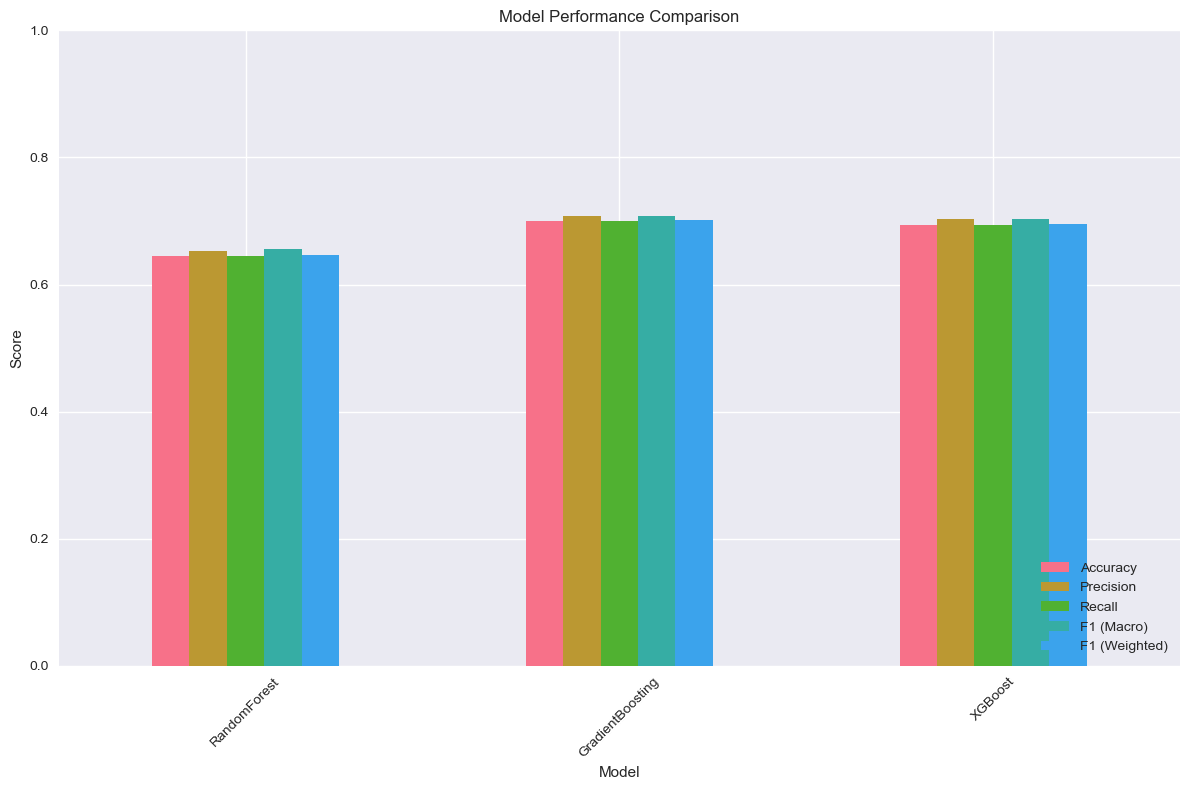

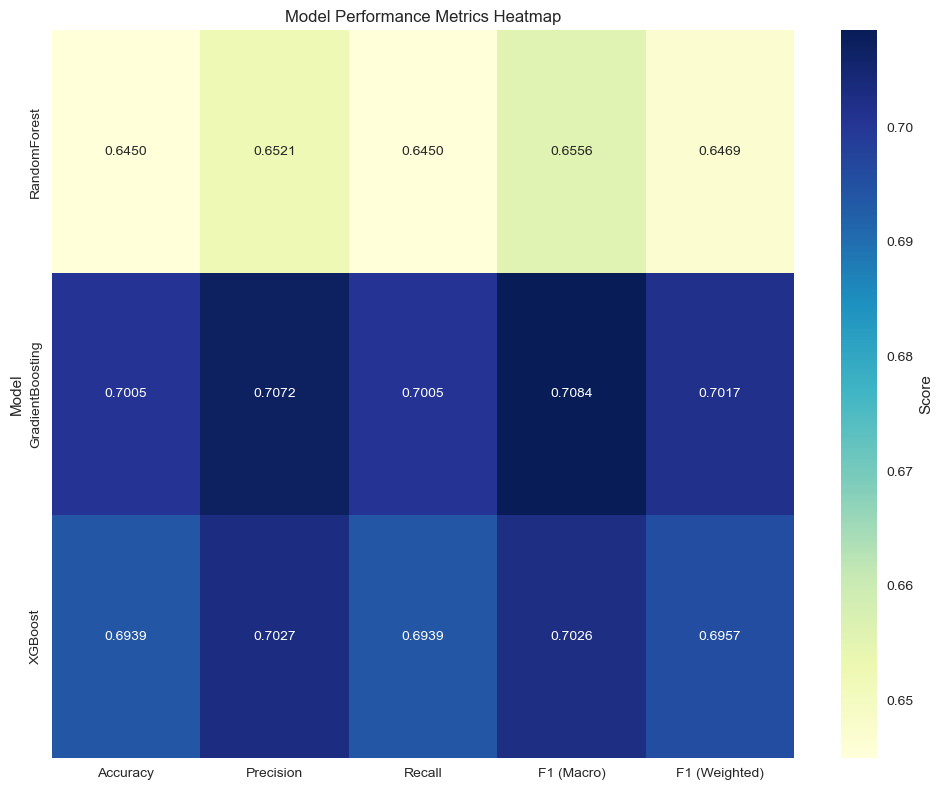


Visualizing prediction distribution...


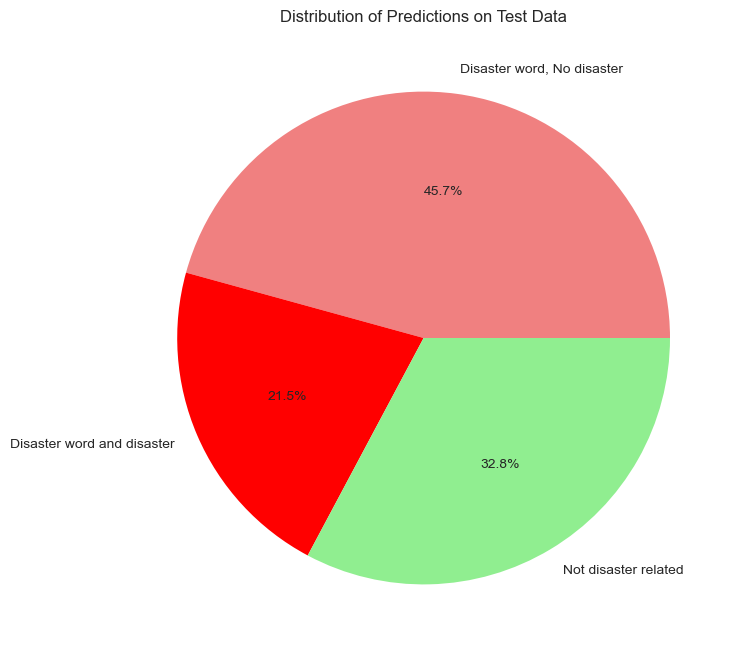

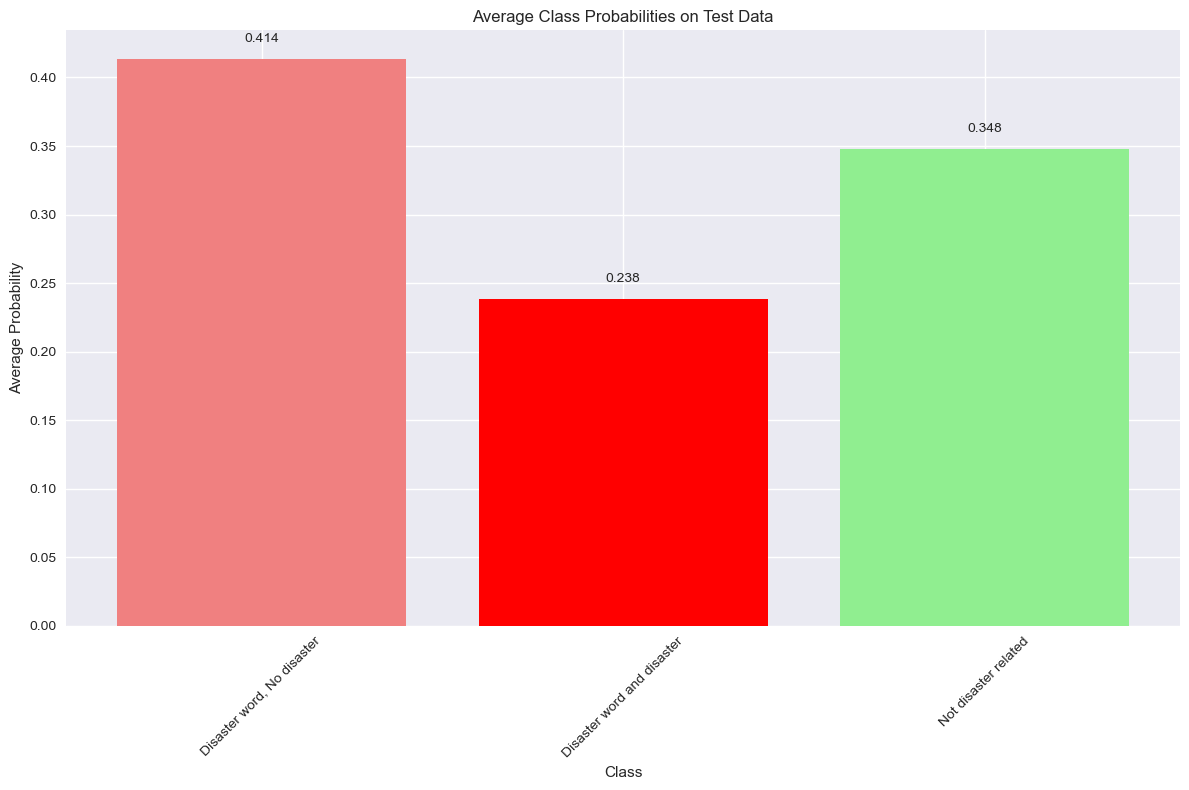


Sample predictions:
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan   
5                 We're shaking...It's an earthquake   
6  They'd probably still show more life than Arse...   
7                                  Hey! How are you?   
8                                   What a nice hat?   
9                                          Fuck off!   

                            predicted_label  class_0_prob  class_1_prob  \
0                      Not disaster related      0.316007      0.297924   
1  Disaster word used and disaster occurred      0.299710      0.354969   
2  Disaster word used and disaster occurred      0.017889      0.947840   
3        Disaster word used but no disaster      0.684334     

In [13]:
# Set your file paths
train_path = "combinedSarcasmDataset.csv"
test_path = "disasterTest.csv"
sentiment_path = "sentimentAnalysis.csv"

# Set your embedding paths (adjust these to your actual paths)
glove_path = "glove.6B.100d.txt\glove.6B.100d.txt"  # Download from https://nlp.stanford.edu/projects/glove/
word2vec_path = "GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin"  # Download from Google

# Execute the main pipeline with embeddings
# Choose 'glove' or 'word2vec' for embedding_type
best_model, test_predictions, results = main_pipeline_with_embeddings(
    train_path=train_path,
    test_path=test_path, 
    sentiment_path=sentiment_path,
    glove_path=glove_path,
    word2vec_path=word2vec_path,
    embedding_type='glove',  # Change to 'word2vec' to use Word2Vec
    eval_method='cv',  # 'cv' for cross-validation, 'split' for simple train-test split
    use_rich_features=True  # Set to False if you don't want rich text features
)

# Visualize the results
print("\nVisualizing model comparison results...")
visualize_model_comparison(results)

print("\nVisualizing prediction distribution...")
visualize_predictions_distribution(test_predictions)

# Show some sample predictions
print("\nSample predictions:")
sample_cols = ['text', 'predicted_label', 'class_0_prob', 'class_1_prob', 'class_2_prob']
if 'target' in test_predictions.columns:
    sample_cols.insert(1, 'target')
print(test_predictions[sample_cols].head(10))

In [14]:
# Example of using the model for a single tweet prediction
def test_single_tweet_prediction():
    """Test the model with a single tweet"""
    
    # Load the best model
    model_path = "best_XGBoost_multiclass_model_with_glove.pkl"  # Adjust to your actual model path
    
    # Test tweets
    test_tweets = [
        {
            "text": "BREAKING: Massive earthquake hits downtown Los Angeles, buildings collapsed. Hundreds feared trapped.",
            "keyword": "earthquake",
            "location": "Los Angeles"
        },
        {
            "text": "I'm just dying of laughter at this earthquake meme! 😂",
            "keyword": "earthquake",
            "location": ""
        },
        {
            "text": "Beautiful sunset this evening, going for a walk now.",
            "keyword": "",
            "location": "New York"
        }
    ]
    
    print("\n===== TESTING SINGLE TWEET PREDICTIONS =====")
    for i, tweet in enumerate(test_tweets):
        print(f"\nTweet {i+1}: {tweet['text']}")
        
        result = predict_single_tweet_with_embeddings(
            tweet['text'], 
            model_path, 
            keyword=tweet['keyword'], 
            location=tweet['location']
        )
        
        print(f"Prediction: {result['prediction_label']} (Class {result['prediction_class']})")
        print(f"Confidence: Class 0: {result['probabilities']['class_0']:.4f}, "
              f"Class 1: {result['probabilities']['class_1']:.4f}, "
              f"Class 2: {result['probabilities']['class_2']:.4f}")
        print(f"Detected Sentiment: {result['sentiment']}")

# Uncomment to test single tweet predictions
# test_single_tweet_prediction()